In [1]:

import matplotlib.pyplot as plt
import numpy as np
import random

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score, roc_curve,roc_auc_score

from sklearn.model_selection import train_test_split
import yfinance as yf
import seaborn as sns
import sys
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score


In [2]:
#https://arxiv.org/abs/1605.00003
#based off paper above, random forest regressor prediction off technicals.  quantopian is source for technicals lib
#https://github.com/eric-kruger/RForest_EquitiesPredict <- did this with R and 

In [3]:
sys.path.append(r'C:\Users\Dan\Desktop\python code\Git\pandas-technical-indicators')
import technical_indicators as ta

In [4]:
def yfinance_data(df,ticker,start_date,end_date):
    df=pd.DataFrame()
    enddate=end_date #yyyy-mm-dd
    startdate=start_date
    ticker=ticker
    data=yf.download(ticker, end=enddate,start=startdate)
    df=df.append(data)
    df.reset_index(inplace=True)
    df.sort_values(by=['Date'], inplace=True, ascending=True)
    return df
    

In [5]:
df=pd.DataFrame()

df=yfinance_data(df,'aapl','2017-01-01','2021-12-30')

[*********************100%***********************]  1 of 1 completed


In [6]:
cols=['Open','High','Low','Close','Volume']
df1=df[cols]
df1=df1.astype('float32')
len(df1)

1257

In [7]:
def get_exp_preprocessing(df, alpha=0.9):
    edata = df.ewm(alpha=alpha).mean()    
    return edata

In [8]:
df2 = get_exp_preprocessing(df1)
df2.head() 

,Open,High,Low,Close,Volume
0,28.950001,29.082500,28.690001,29.037500,1.151276e+08
1,28.961363,29.123410,28.915000,29.007954,8.725924e+07
2,28.978153,29.205924,28.948783,29.138176,8.862425e+07
3,29.173335,29.506623,29.100644,29.443599,1.231727e+08
4,29.456086,29.822416,29.446568,29.717112,1.331402e+08


In [9]:
def feature_extraction(data):
    for x in [5, 14, 26, 44, 66]:
        data = ta.relative_strength_index(data, n=x)
        data = ta.stochastic_oscillator_d(data, n=x)
        data = ta.accumulation_distribution(data, n=x)
        data = ta.average_true_range(data, n=x)
        data = ta.momentum(data, n=x)
        data = ta.money_flow_index(data, n=x)
        data = ta.rate_of_change(data, n=x)
        data = ta.on_balance_volume(data, n=x)
        data = ta.commodity_channel_index(data, n=x)
        data = ta.ease_of_movement(data, n=x)
        data = ta.trix(data, n=x)
        data = ta.vortex_indicator(data, n=x)
    
    data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
    data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
    data['ema14'] = data['Close'] / data['Close'].ewm(14).mean()
    data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()
        
    
    data = ta.macd(data, n_fast=12, n_slow=26)
    
    del(data['Open'])
    del(data['High'])
    del(data['Low'])
    del(data['Volume'])
    
    return data
   
def compute_prediction_int(df, n):
    pred = (df.shift(-n)['Close'] >= df['Close'])
    pred = pred.iloc[:-n]
    return pred.astype(int)

def prepare_data(df, horizon):
    data = feature_extraction(df).dropna().iloc[:-horizon]
    data['pred'] = compute_prediction_int(data, n=horizon)
    del(data['Close'])
    return data.dropna()

In [10]:
data = prepare_data(df2, 10)

y = data['pred']

#remove the output from input
features = [x for x in data.columns if x not in ['gain', 'pred']]
X = data[features]

In [11]:
len(data)

1041

In [12]:
data

,RSI_5,SO%d_5,Acc/Dist_ROC_5,ATR_5,Momentum_5,MFI_5,ROC_5,OBV_5,CCI_5,EoM_5,...,Trix_66,Vortex_66,ema50,ema21,ema14,ema5,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,pred
196,0.902082,0.419295,-1.864747,0.418938,0.210008,0.8,0.004878,4.038838e+07,0.636249,5.889923e-10,...,0.000662,0.081584,1.016018,1.000417,1.000077,1.004027,-0.135133,-0.220488,0.085355,1.0
197,0.902082,0.475161,-1.495817,0.382425,0.401251,0.8,0.007130,3.926317e+07,1.445969,5.738646e-10,...,0.000655,0.080233,1.021096,1.005582,1.005139,1.007887,-0.095830,-0.195556,0.099726,1.0
198,0.977894,0.627929,-3.904778,0.491013,0.949127,0.8,0.023691,4.480884e+07,1.756278,8.747077e-10,...,0.000649,0.082976,1.037774,1.021737,1.020824,1.020863,-0.010383,-0.158522,0.148139,1.0
199,0.985148,0.678350,3.213202,0.468754,1.123164,0.8,0.024905,4.779722e+07,1.391611,9.544500e-10,...,0.000644,0.082172,1.042079,1.025604,1.024168,1.021555,0.072627,-0.112292,0.184919,1.0
200,0.985148,0.531015,-0.094989,0.409894,0.834565,0.6,0.024183,2.102544e+07,0.901616,1.033247e-09,...,0.000639,0.067988,1.037649,1.021007,1.019199,1.014950,0.125686,-0.064696,0.190383,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232,0.811179,0.587355,1.087506,3.852943,10.465346,0.8,0.053073,1.106251e+08,0.707227,8.819051e-08,...,0.000979,0.150930,1.104752,1.073968,1.064086,1.037733,3.089310,1.940933,1.148377,1.0
1233,0.811179,0.691127,-0.363390,3.416457,8.651532,0.8,0.028438,1.079217e+08,0.543951,6.891326e-08,...,0.000981,0.137815,1.105958,1.073644,1.062726,1.033994,3.398443,2.232435,1.166008,1.0
1234,0.428282,0.514417,-1.561063,4.010525,-0.088845,0.6,-0.018213,6.609615e+07,-1.282618,2.304809e-08,...,0.000984,0.100404,1.073196,1.041315,1.030507,1.004026,3.237745,2.433497,0.804248,1.0
1235,0.491767,0.521568,-1.065234,3.945574,-0.287882,0.6,-0.006175,5.983316e+07,-0.393105,7.665551e-09,...,0.000987,0.120655,1.089195,1.055908,1.044414,1.017285,3.284786,2.603755,0.681031,1.0


In [13]:
train_size = 2*len(X) // 3

X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

len(X_train),len(y_train),len(X_test),len(y_test)

(694, 694, 347, 347)

In [14]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=42)
rf.fit(X_train, y_train.values.ravel());

In [15]:
pred = rf.predict(X_test)
precision = precision_score(y_pred=pred, y_true=y_test)
recall = recall_score(y_pred=pred, y_true=y_test)
f1 = f1_score(y_pred=pred, y_true=y_test)
accuracy = accuracy_score(y_pred=pred, y_true=y_test)
confusion = confusion_matrix(y_pred=pred, y_true=y_test)
print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy: {3:1.2f}'.format(precision, recall, f1, accuracy))
print('Confusion Matrix')
print(confusion)

precision: 0.65, recall: 0.70, f1: 0.67, accuracy: 0.58
Confusion Matrix
[[ 49  81]
 [ 66 151]]


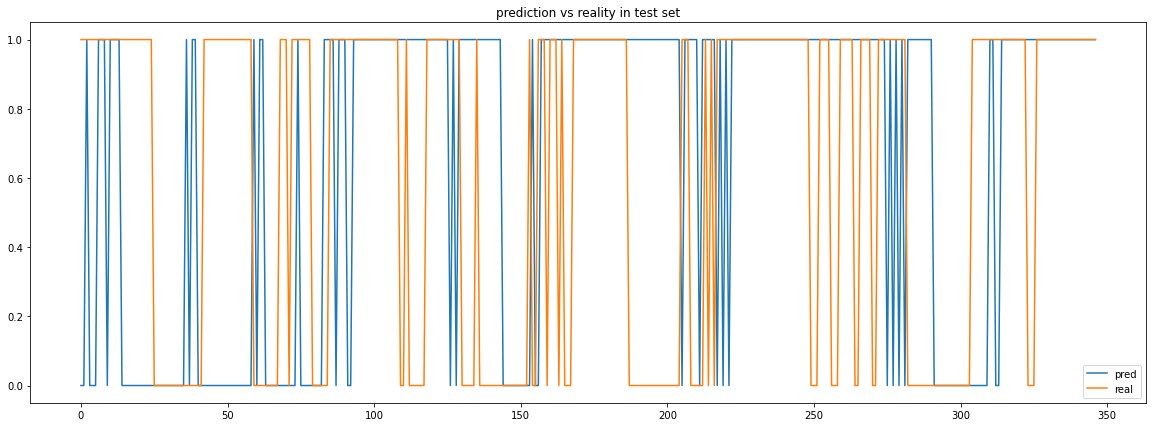

In [16]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(pred)), pred, label='pred')
plt.plot(np.arange(len(y_test)), y_test, label='real')
plt.title('prediction vs reality in test set')
plt.legend()

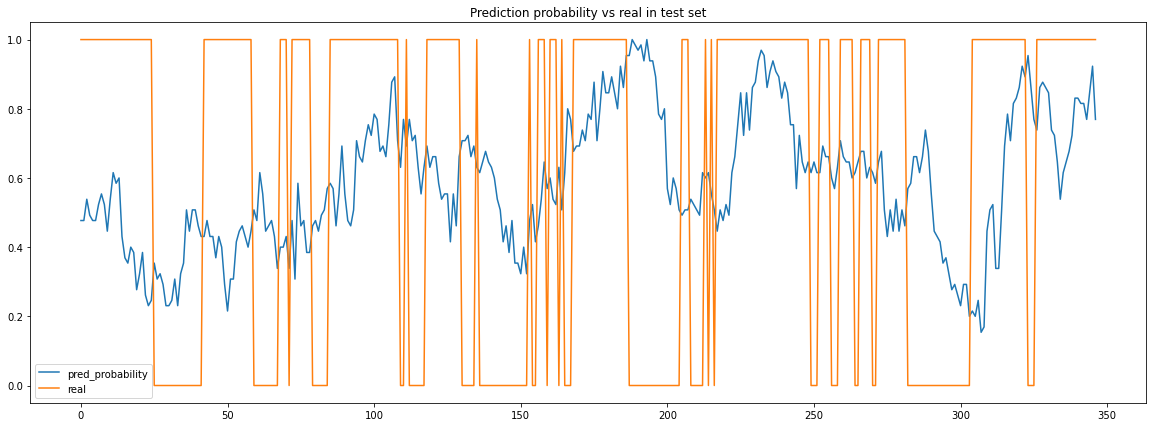

In [17]:
proba = rf.predict_proba(X_test)[:,1]
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(proba)), proba, label='pred_probability')
plt.plot(np.arange(len(y_test)), y_test, label='real')
plt.title('Prediction probability vs real in test set')
plt.legend()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 2*len(X) // 3)

len(X_train),len(y_train),len(X_test),len(y_test)

(694, 694, 347, 347)

In [19]:
rf2 = RandomForestClassifier(n_jobs=-1, n_estimators=65, random_state=42)
rf2.fit(X_train, y_train.values.ravel());

In [20]:
pred = rf2.predict(X_test)
precision = precision_score(y_pred=pred, y_true=y_test)
recall = recall_score(y_pred=pred, y_true=y_test)
f1 = f1_score(y_pred=pred, y_true=y_test)
accuracy = accuracy_score(y_pred=pred, y_true=y_test)
confusion = confusion_matrix(y_pred=pred, y_true=y_test)
print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy: {3:1.2f}'.format(precision, recall, f1, accuracy))
print('Confusion Matrix')
print(confusion)

precision: 0.88, recall: 0.94, f1: 0.91, accuracy: 0.87
Confusion Matrix
[[ 82  30]
 [ 15 220]]


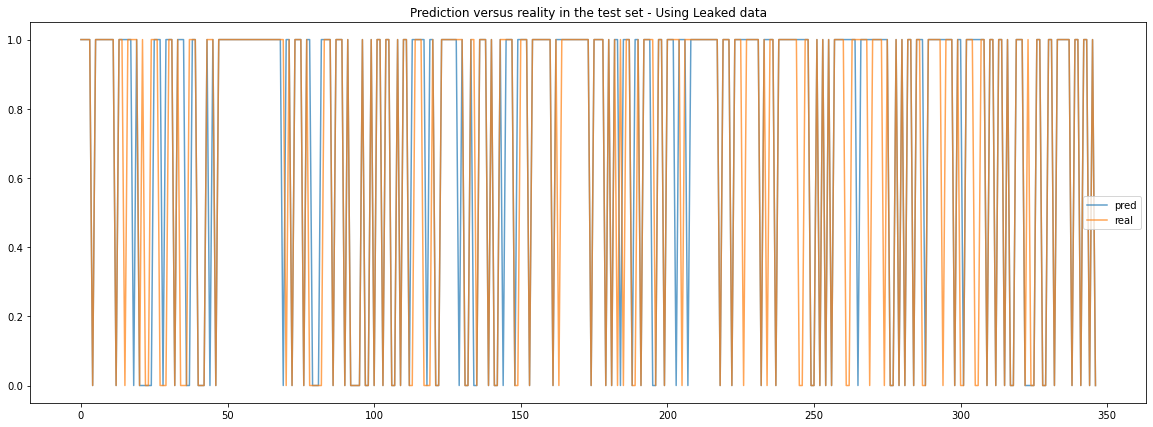

In [21]:
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(pred)), pred, alpha=0.7, label='pred')
plt.plot(np.arange(len(y_test)), y_test, alpha=0.7, label='real' );
plt.title('Prediction versus reality in the test set - Using Leaked data')
plt.legend();

<Figure size 1440x504 with 0 Axes>

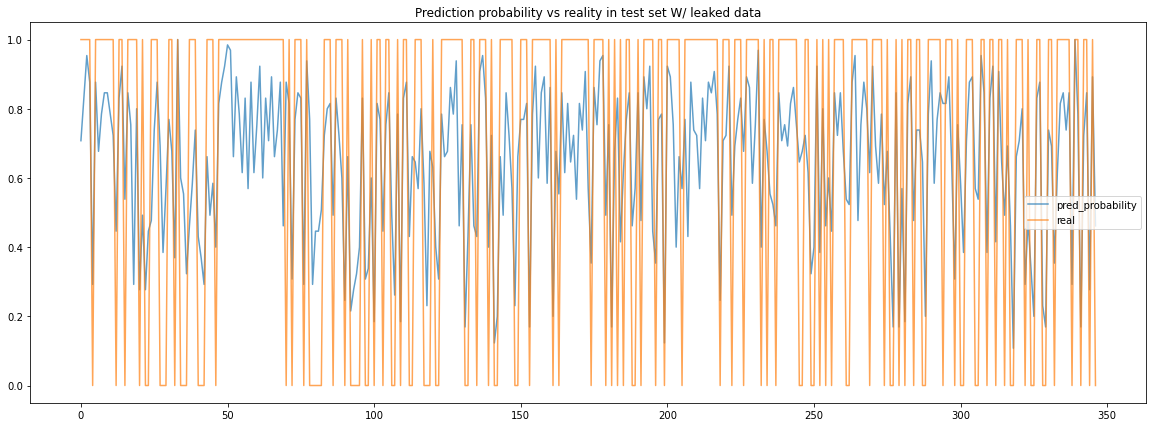

In [22]:
plt.figure(figsize=(20,7))
proba = rf2.predict_proba(X_test)[:,1]
plt.figure(figsize=(20,7))
plt.plot(np.arange(len(proba)), proba, alpha = 0.7, label='pred_probability')
plt.plot(np.arange(len(y_test)), y_test, alpha = 0.7, label='real' );
plt.title('Prediction probability vs reality in test set W/ leaked data');
plt.legend();
plt.show();

In [23]:
cross_val_score(rf2, X_test,y_test,cv=5)

array([0.78571429, 0.82857143, 0.82608696, 0.72463768, 0.82608696])

In [24]:
#calc fpr, tpr, and threshold
fpr, tpr, thresholds= roc_curve(y_test, proba)

# check false positive rates
fpr

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00892857,
       0.00892857, 0.00892857, 0.01785714, 0.02678571, 0.02678571,
       0.02678571, 0.03571429, 0.03571429, 0.03571429, 0.03571429,
       0.03571429, 0.04464286, 0.08035714, 0.09821429, 0.11607143,
       0.11607143, 0.13392857, 0.14285714, 0.16071429, 0.19642857,
       0.21428571, 0.24107143, 0.25892857, 0.26785714, 0.3125    ,
       0.33035714, 0.375     , 0.42857143, 0.47321429, 0.48214286,
       0.53571429, 0.57142857, 0.58928571, 0.61607143, 0.63392857,
       0.66071429, 0.69642857, 0.75      , 0.78571429, 0.79464286,
       0.8125    , 0.83928571, 0.84821429, 0.88392857, 0.91071429,
       0.97321429, 0.99107143, 1.        ])

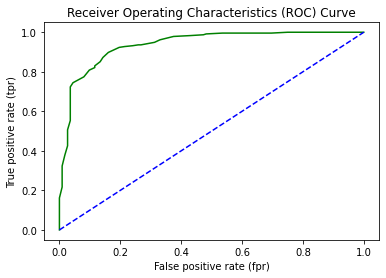

In [25]:
def plot_roc_curve(fpr,tpr):
    plt.plot(fpr,tpr,color='green',label='ROC')
    plt.plot([0,1],[0,1], color = 'blue', linestyle ='--',label='guessing')
    
    plt.xlabel('False positive rate (fpr)')
    plt.ylabel('True positive rate (tpr)')
    plt.title('Receiver Operating Characteristics (ROC) Curve')
    
plot_roc_curve(fpr,tpr)

In [26]:
roc_auc_score(y_test,proba)

0.9375379939209727

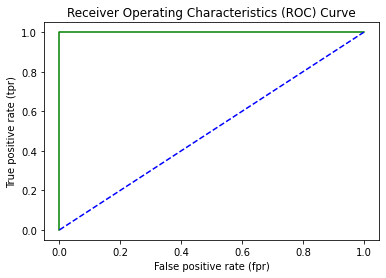

In [27]:
#plt perfect ROC AND auc score
fpr, tpr, thrresholds = roc_curve(y_test, y_test)
plot_roc_curve(fpr,tpr)